# pycisTopic analysis

Full dataset, using SCREEN regions.

In [1]:
import pycisTopic

pycisTopic.__version__

%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
import pickle
import pandas as pd

In [4]:
import glob
from collections import OrderedDict
import numpy as np

In [5]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [6]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/public_3_cistopic_qc


In [7]:
!cat ../0_resources/scripts/runModels_lda_mallet.py

import pickle
import sys
import argparse
import os
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *

def make_argument_parser():
    """
    Creates an ArgumentParser to read the options for this script from
    sys.argv
    """
    parser = argparse.ArgumentParser(
        description="Run topic models.",)
    parser.add_argument('--inputcisTopic_obj', '-i', type=str, required=True,
                        help='Path to cisTopic object pickle file.')
    parser.add_argument('--output', '-o', type=str, required=True,
                        help='Path to save final model list.')
    parser.add_argument('--n_topics', '-nt', type=str, required=True, nargs='+',
                        help='Txt file containing selected topic id.')
    parser.add_argument('--n_cpu', '-c', type=int, required=True,
                        help = 'Number of cores')
    parser.add_argument('--n_iter', '-it', type=int, required=False, default=150,
                        help = 'Numbe

In [8]:
import os

wdir = "/lustre1/project/stg_00090/scatac_benchmark/public_3_cistopic_qc"
os.chdir(wdir)

In [9]:
scrub_name_suffix = "0-4"
cto_paths = sorted(
    glob.glob(f"cistopic_objects/*__cto.scrublet{scrub_name_suffix}.fmx.singlets.pkl")
)
cistopic_obj_path_dict = {
    x.split("/")[-1].split(f"__cto.scrublet{scrub_name_suffix}.fmx.singlets.pkl")[0]: x
    for x in cto_paths
}
cistopic_obj_path_dict

{'BIO_ddseq_m1c1.FULL': 'cistopic_objects/BIO_ddseq_m1c1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c2.FULL': 'cistopic_objects/BIO_ddseq_m1c2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c3.FULL': 'cistopic_objects/BIO_ddseq_m1c3.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c4.FULL': 'cistopic_objects/BIO_ddseq_m1c4.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c5.FULL': 'cistopic_objects/BIO_ddseq_m1c5.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c6.FULL': 'cistopic_objects/BIO_ddseq_m1c6.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c7.FULL': 'cistopic_objects/BIO_ddseq_m1c7.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c8.FULL': 'cistopic_objects/BIO_ddseq_m1c8.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c1.FULL': 'cistopic_objects/BIO_ddseq_m2c1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c2.FULL': 'cistopic_objects/BIO_ddseq_m2c2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c3.FUL

In [10]:
n_topics_final = 50
topics_final = set([str(x + 1) for x in list(range(1, n_topics_final))])
n_cores = 36
n_iter = "400"

In [11]:
mounts = "/lustre1,/staging,/data,/vsc-hard-mounts,/scratch"
sif = "../0_resources/cistopic_image/20220815_pycistopic.sif"
script = "../0_resources/scripts/runModels_lda_mallet.py"

f_mod_dir = "models__screen__mallet"
if not os.path.exists(os.path.join(wdir, f_mod_dir)):
    os.makedirs(os.path.join(wdir, f_mod_dir))

for sample in cistopic_obj_path_dict.keys():
    infile = cistopic_obj_path_dict[sample]
    outfile = os.path.join(f_mod_dir, sample + "__models_" + str(n_iter) + "_iter.pkl")

    intermediate_dir = f"{f_mod_dir}/model_intermediates/{sample}_model_intermediates/"

    if not os.path.exists(os.path.join(wdir, intermediate_dir)):
        os.makedirs(os.path.join(wdir, intermediate_dir))
    else:
        print(f"{intermediate_dir} already exists!")

    n_topics_detected = len(os.listdir(os.path.join(wdir, intermediate_dir)))
    if not n_topics_detected == n_topics_final:
        model_tmp_dir = f"{f_mod_dir}/model_tmp/{sample}_model_tmp/"
        if not os.path.exists(os.path.join(wdir, model_tmp_dir)):
            os.makedirs(os.path.join(wdir, model_tmp_dir))

        topics_detected = set(
            [
                x.replace("Topic", "").replace(".pkl", "")
                for x in os.listdir(os.path.join(wdir, intermediate_dir))
            ]
        )
        topics_todo = (
            str(sorted(list(topics_final - topics_detected)))
            .replace("'", "")
            .replace(" ", "")
            .replace("[", "")
            .replace("]", "")
        )
        ver = str(n_topics_final)

        if not topics_todo == "":
            out_log = f"{f_mod_dir}/{sample}.models_out_log{ver}.txt"
            cmd = f"echo {sample} && cd {wdir} && singularity exec -B {mounts} {sif} python {script} -i {infile} -o {outfile} -nt {topics_todo} -c {n_cores} -it {n_iter} -a 50 -abt True -e 0.1 -ebt False -sp {intermediate_dir} -s 555 -td {model_tmp_dir} > {out_log}"

            print(cmd)
            sh_path = f"{f_mod_dir}/{sample}.runmodels{ver}.sh"
            with open(sh_path, "w") as file:
                file.write(cmd)
        else:
            print("All topics done.")

    print("\n")

models__screen__mallet/model_intermediates/BIO_ddseq_m1c1.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c2.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c3.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c4.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c5.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c6.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c7.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_ddseq_m1c8.FULL_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/BIO_d

In shell:

In [172]:
for script in models__screen__mallet/*50.sh
do
    echo $script
    qsub $script -A lp_symbiosys -l nodes=1:ppn=36 -l walltime=24:00:00 -l pmem=2gb
done

SyntaxError: invalid syntax (1446407723.py, line 1)

Then, combine the models:

In [12]:
intermediate_dict = {
    x.split("/")[-1].split("_model_intermediates")[0]: x
    for x in sorted(glob.glob(f"{f_mod_dir}/model_intermediates/*"))
}
intermediate_dict

{'BIO_ddseq_m1c1.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c1.FULL_model_intermediates',
 'BIO_ddseq_m1c2.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c2.FULL_model_intermediates',
 'BIO_ddseq_m1c3.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c3.FULL_model_intermediates',
 'BIO_ddseq_m1c4.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c4.FULL_model_intermediates',
 'BIO_ddseq_m1c5.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c5.FULL_model_intermediates',
 'BIO_ddseq_m1c6.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c6.FULL_model_intermediates',
 'BIO_ddseq_m1c7.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c7.FULL_model_intermediates',
 'BIO_ddseq_m1c8.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m1c8.FULL_model_intermediates',
 'BIO_ddseq_m2c1.FULL': 'models__screen__mallet/model_intermediates/BIO_ddseq_m2c1.FULL_model_intermediates',
 'BIO_ddse

In [13]:
for sample, directory in intermediate_dict.items():
    nmodels = len(os.listdir(directory))
    print(f"{nmodels} models in {directory}")
    save_path = f"{f_mod_dir}/{sample}__models_{n_iter}_iter.pkl"
    if not os.path.exists(save_path):
        file_list = sorted(os.listdir(directory))
        n_topics = [int(x.split("Topic")[-1].split(".pkl")[0]) for x in file_list]
        file_list_sorted = [file_list[x] for x in np.argsort(n_topics)]

        if len(os.listdir(directory)) == n_topics_final - 1:
            print(f"\tsaving at {save_path}")

            models_merged = [
                pickle.load(open(f"{directory}/{file}", "rb"))
                for file in file_list_sorted
            ]

            with open(save_path, "wb") as f:
                pickle.dump(models_merged, f, protocol=4)

        else:
            print(
                f"\tn_models < {n_topics_final}, {len(sorted(os.listdir(directory)))}"
            )
    else:
        print(f"\t{save_path} exists, skipping")

49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c1.FULL_model_intermediates
	models__screen__mallet/BIO_ddseq_m1c1.FULL__models_400_iter.pkl exists, skipping
49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c2.FULL_model_intermediates
	models__screen__mallet/BIO_ddseq_m1c2.FULL__models_400_iter.pkl exists, skipping
49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c3.FULL_model_intermediates
	models__screen__mallet/BIO_ddseq_m1c3.FULL__models_400_iter.pkl exists, skipping
49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c4.FULL_model_intermediates
	models__screen__mallet/BIO_ddseq_m1c4.FULL__models_400_iter.pkl exists, skipping
49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c5.FULL_model_intermediates
	models__screen__mallet/BIO_ddseq_m1c5.FULL__models_400_iter.pkl exists, skipping
49 models in models__screen__mallet/model_intermediates/BIO_ddseq_m1c6.FULL_model_intermediates
	models__scree

In [14]:
from pycisTopic.lda_models import evaluate_models
import matplotlib.pyplot as plt

In [15]:
scrub_name_suffix = "0-4"
cto_paths = sorted(
    glob.glob(f"cistopic_objects/*__cto.scrublet{scrub_name_suffix}.fmx.singlets.pkl")
)
cto_singlets_path_dict = {
    x.split("/")[-1].split(f"__cto.scrublet{scrub_name_suffix}.fmx.singlets.pkl")[0]: x
    for x in cto_paths
}
cto_singlets_path_dict

{'BIO_ddseq_m1c1.FULL': 'cistopic_objects/BIO_ddseq_m1c1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c2.FULL': 'cistopic_objects/BIO_ddseq_m1c2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c3.FULL': 'cistopic_objects/BIO_ddseq_m1c3.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c4.FULL': 'cistopic_objects/BIO_ddseq_m1c4.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c5.FULL': 'cistopic_objects/BIO_ddseq_m1c5.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c6.FULL': 'cistopic_objects/BIO_ddseq_m1c6.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c7.FULL': 'cistopic_objects/BIO_ddseq_m1c7.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m1c8.FULL': 'cistopic_objects/BIO_ddseq_m1c8.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c1.FULL': 'cistopic_objects/BIO_ddseq_m2c1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c2.FULL': 'cistopic_objects/BIO_ddseq_m2c2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_m2c3.FUL

In [16]:
n_iter = 400

In [17]:
models_path_dict = {
    x.split("/")[-1].split(f"__models_{n_iter}_iter.pkl")[0]: x
    for x in sorted(glob.glob(f"{f_mod_dir}/*{n_iter}_iter.pkl"))
}
models_path_dict

{'BIO_ddseq_m1c1.FULL': 'models__screen__mallet/BIO_ddseq_m1c1.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c2.FULL': 'models__screen__mallet/BIO_ddseq_m1c2.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c3.FULL': 'models__screen__mallet/BIO_ddseq_m1c3.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c4.FULL': 'models__screen__mallet/BIO_ddseq_m1c4.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c5.FULL': 'models__screen__mallet/BIO_ddseq_m1c5.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c6.FULL': 'models__screen__mallet/BIO_ddseq_m1c6.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c7.FULL': 'models__screen__mallet/BIO_ddseq_m1c7.FULL__models_400_iter.pkl',
 'BIO_ddseq_m1c8.FULL': 'models__screen__mallet/BIO_ddseq_m1c8.FULL__models_400_iter.pkl',
 'BIO_ddseq_m2c1.FULL': 'models__screen__mallet/BIO_ddseq_m2c1.FULL__models_400_iter.pkl',
 'BIO_ddseq_m2c2.FULL': 'models__screen__mallet/BIO_ddseq_m2c2.FULL__models_400_iter.pkl',
 'BIO_ddseq_m2c3.FULL': 'models__screen__mallet/BIO_ddseq_m2c3.FULL__models_400_iter.pkl',

We need to minimize Arun, minimize Cao & Juan, maximize Mimno & maximize log likelihood

In [25]:
optimal_topics_dict = {
    "BIO_ddseq_m1c1.FULL": 12,
    "BIO_ddseq_m1c2.FULL": 12,
    "BIO_ddseq_m1c3.FULL": 15,
    "BIO_ddseq_m1c4.FULL": 10,
    "BIO_ddseq_m1c5.FULL": 10,
    "BIO_ddseq_m1c6.FULL": 10,
    "BIO_ddseq_m1c7.FULL": 15,
    "BIO_ddseq_m1c8.FULL": 17,
    "BIO_ddseq_m2c1.FULL": 12,
    "BIO_ddseq_m2c2.FULL": 9,
    "BIO_ddseq_m2c3.FULL": 9,
    "BIO_ddseq_m2c4.FULL": 12,
    "OHS_s3atac_mouse.FULL": 9,
    "TXG_10xmultiome_e18mousebrainfresh.FULL": 18,
    "TXG_10xv11_adultmousecortexchromiumx.FULL": 18,
    "TXG_10xv1_adultmousefresh.FULL": 20,
    "TXG_10xv2_adultmousecortex.FULL": 19,
    "TXG_10xv2_adultmousecortexchromiumx.FULL": 15,
    "VIB_hydrop_1.FULL": 19,
    "VIB_hydrop_2.FULL": 14,
    "VIB_hydrop_3.FULL": 14,
    "VIB_hydrop_4.FULL": 15,
    "VIB_hydrop_5.FULL": 12,
}

In [26]:
for sample in models_path_dict.keys():
    if sample not in optimal_topics_dict.keys():
        print(f"adding {sample}")
        optimal_topics_dict[sample] = 10
    else:
        print(f"{sample} in optimal_topics_dict")

optimal_topics_dict

BIO_ddseq_m1c1.FULL in optimal_topics_dict
BIO_ddseq_m1c2.FULL in optimal_topics_dict
BIO_ddseq_m1c3.FULL in optimal_topics_dict
BIO_ddseq_m1c4.FULL in optimal_topics_dict
BIO_ddseq_m1c5.FULL in optimal_topics_dict
BIO_ddseq_m1c6.FULL in optimal_topics_dict
BIO_ddseq_m1c7.FULL in optimal_topics_dict
BIO_ddseq_m1c8.FULL in optimal_topics_dict
BIO_ddseq_m2c1.FULL in optimal_topics_dict
BIO_ddseq_m2c2.FULL in optimal_topics_dict
BIO_ddseq_m2c3.FULL in optimal_topics_dict
BIO_ddseq_m2c4.FULL in optimal_topics_dict
OHS_s3atac_mouse.FULL in optimal_topics_dict
TXG_10xmultiome_e18mousebrainfresh.FULL in optimal_topics_dict
TXG_10xv11_adultmousecortexchromiumx.FULL in optimal_topics_dict
TXG_10xv1_adultmousefresh.FULL in optimal_topics_dict
TXG_10xv2_adultmousecortex.FULL in optimal_topics_dict
TXG_10xv2_adultmousecortexchromiumx.FULL in optimal_topics_dict
VIB_hydrop_1.FULL in optimal_topics_dict
VIB_hydrop_2.FULL in optimal_topics_dict
VIB_hydrop_3.FULL in optimal_topics_dict
VIB_hydrop_4.FU

{'BIO_ddseq_m1c1.FULL': 12,
 'BIO_ddseq_m1c2.FULL': 12,
 'BIO_ddseq_m1c3.FULL': 15,
 'BIO_ddseq_m1c4.FULL': 10,
 'BIO_ddseq_m1c5.FULL': 10,
 'BIO_ddseq_m1c6.FULL': 10,
 'BIO_ddseq_m1c7.FULL': 10,
 'BIO_ddseq_m1c8.FULL': 10,
 'BIO_ddseq_m2c1.FULL': 12,
 'BIO_ddseq_m2c2.FULL': 9,
 'BIO_ddseq_m2c3.FULL': 9,
 'BIO_ddseq_m2c4.FULL': 10,
 'OHS_s3atac_mouse.FULL': 9,
 'TXG_10xmultiome_e18mousebrainfresh.FULL': 18,
 'TXG_10xv11_adultmousecortexchromiumx.FULL': 18,
 'TXG_10xv1_adultmousefresh.FULL': 20,
 'TXG_10xv2_adultmousecortex.FULL': 18,
 'TXG_10xv2_adultmousecortexchromiumx.FULL': 15,
 'VIB_hydrop_1.FULL': 19,
 'VIB_hydrop_2.FULL': 14,
 'VIB_hydrop_3.FULL': 14,
 'VIB_hydrop_4.FULL': 15,
 'VIB_hydrop_5.FULL': 12}

In [27]:
from pycisTopic.lda_models import evaluate_models
import matplotlib.pyplot as plt

BIO_ddseq_m1c1.FULL
cistopic_objects/BIO_ddseq_m1c1.FULL__cto.scrublet0-4.fmx.singlets.model_12topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c1.FULL__models_400_iter.pkl, evaluating...


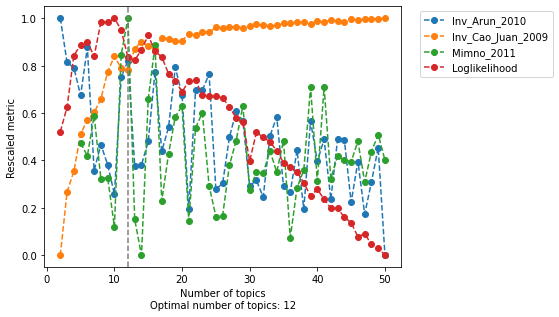

BIO_ddseq_m1c2.FULL
cistopic_objects/BIO_ddseq_m1c2.FULL__cto.scrublet0-4.fmx.singlets.model_12topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c2.FULL__models_400_iter.pkl, evaluating...


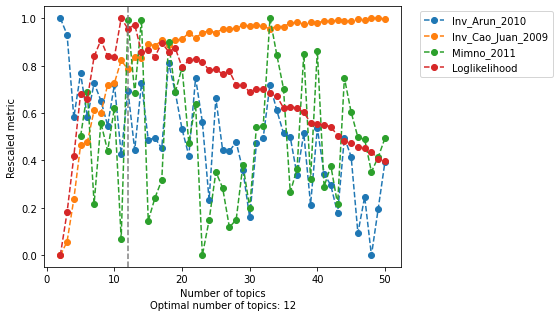

BIO_ddseq_m1c3.FULL
cistopic_objects/BIO_ddseq_m1c3.FULL__cto.scrublet0-4.fmx.singlets.model_15topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c3.FULL__models_400_iter.pkl, evaluating...


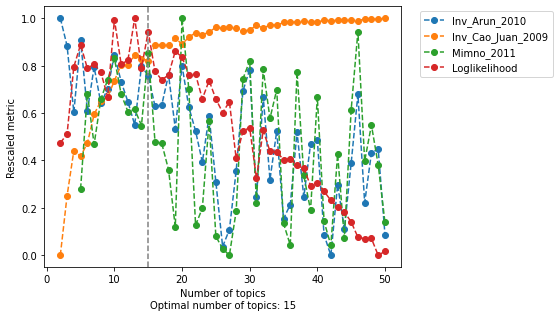

BIO_ddseq_m1c4.FULL
cistopic_objects/BIO_ddseq_m1c4.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c4.FULL__models_400_iter.pkl, evaluating...


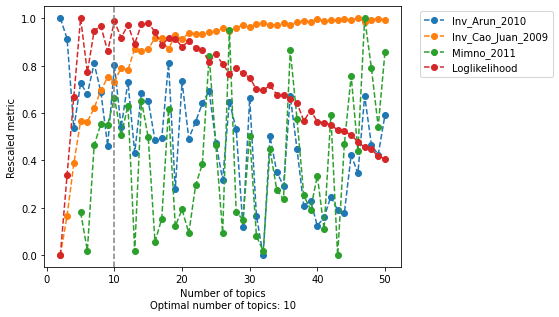

BIO_ddseq_m1c5.FULL
cistopic_objects/BIO_ddseq_m1c5.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c5.FULL__models_400_iter.pkl, evaluating...


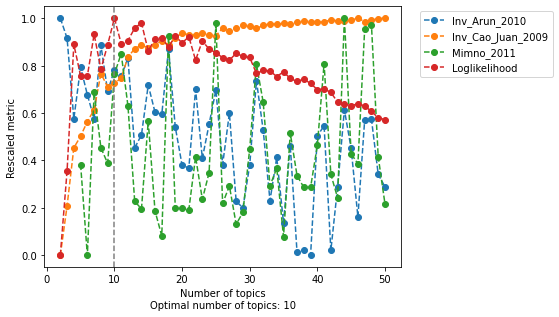

BIO_ddseq_m1c6.FULL
cistopic_objects/BIO_ddseq_m1c6.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c6.FULL__models_400_iter.pkl, evaluating...


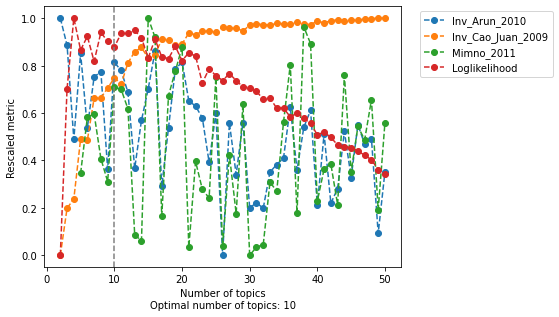

BIO_ddseq_m1c7.FULL
cistopic_objects/BIO_ddseq_m1c7.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c7.FULL__models_400_iter.pkl, evaluating...


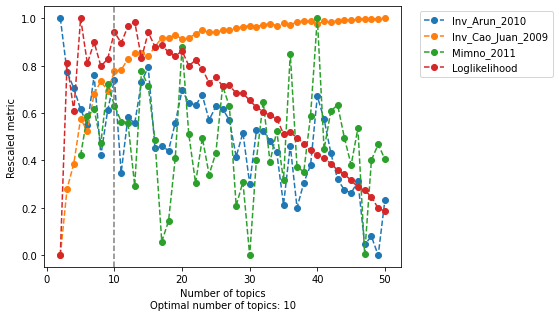

BIO_ddseq_m1c8.FULL
cistopic_objects/BIO_ddseq_m1c8.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m1c8.FULL__models_400_iter.pkl, evaluating...


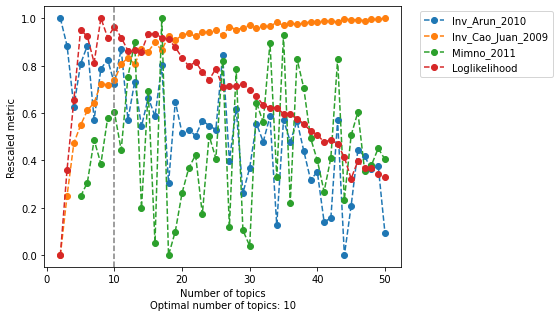

BIO_ddseq_m2c1.FULL
cistopic_objects/BIO_ddseq_m2c1.FULL__cto.scrublet0-4.fmx.singlets.model_12topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m2c1.FULL__models_400_iter.pkl, evaluating...


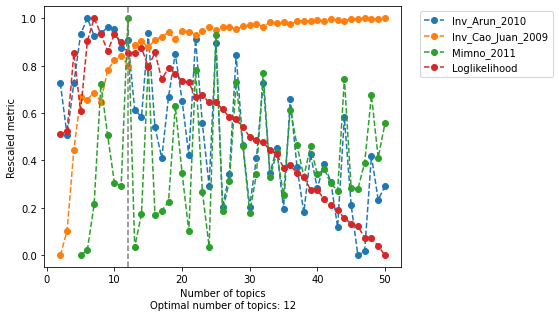

BIO_ddseq_m2c2.FULL
cistopic_objects/BIO_ddseq_m2c2.FULL__cto.scrublet0-4.fmx.singlets.model_9topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m2c2.FULL__models_400_iter.pkl, evaluating...


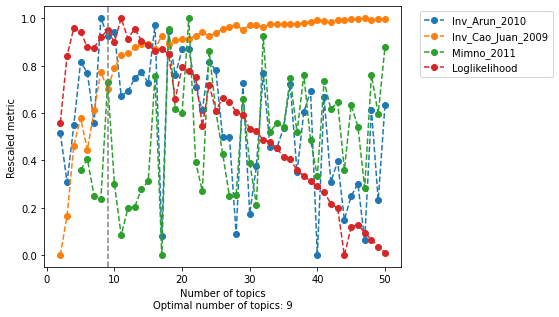

BIO_ddseq_m2c3.FULL
cistopic_objects/BIO_ddseq_m2c3.FULL__cto.scrublet0-4.fmx.singlets.model_9topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m2c3.FULL__models_400_iter.pkl, evaluating...


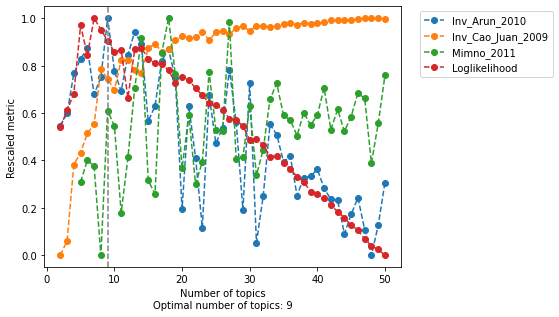

BIO_ddseq_m2c4.FULL
cistopic_objects/BIO_ddseq_m2c4.FULL__cto.scrublet0-4.fmx.singlets.model_10topics.pkl
	Loaded models__screen__mallet/BIO_ddseq_m2c4.FULL__models_400_iter.pkl, evaluating...


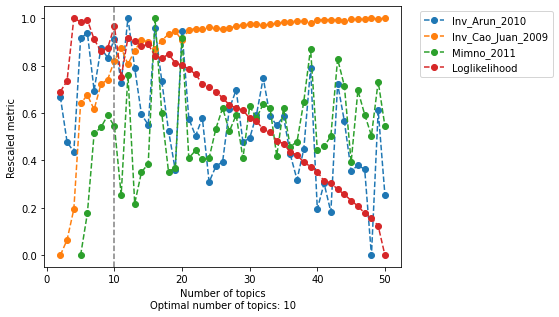

OHS_s3atac_mouse.FULL
cistopic_objects/OHS_s3atac_mouse.FULL__cto.scrublet0-4.fmx.singlets.model_9topics.pkl
	Loaded models__screen__mallet/OHS_s3atac_mouse.FULL__models_400_iter.pkl, evaluating...


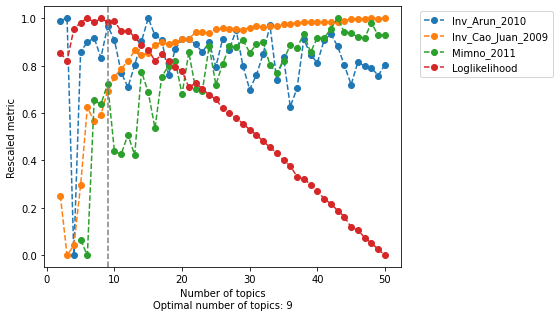

TXG_10xmultiome_e18mousebrainfresh.FULL
cistopic_objects/TXG_10xmultiome_e18mousebrainfresh.FULL__cto.scrublet0-4.fmx.singlets.model_18topics.pkl
	Loaded models__screen__mallet/TXG_10xmultiome_e18mousebrainfresh.FULL__models_400_iter.pkl, evaluating...


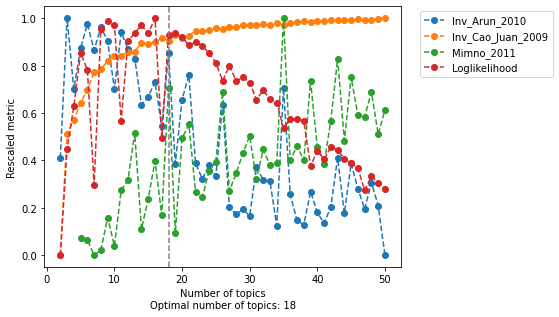

TXG_10xv11_adultmousecortexchromiumx.FULL
cistopic_objects/TXG_10xv11_adultmousecortexchromiumx.FULL__cto.scrublet0-4.fmx.singlets.model_18topics.pkl
	Loaded models__screen__mallet/TXG_10xv11_adultmousecortexchromiumx.FULL__models_400_iter.pkl, evaluating...


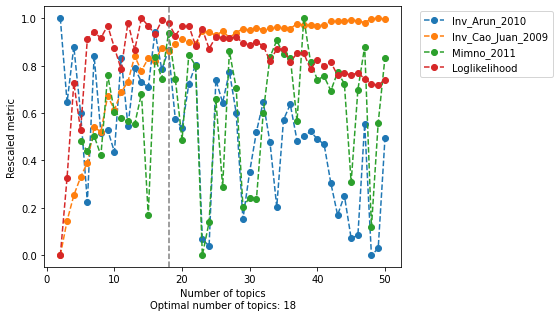

TXG_10xv1_adultmousefresh.FULL
cistopic_objects/TXG_10xv1_adultmousefresh.FULL__cto.scrublet0-4.fmx.singlets.model_20topics.pkl
	Loaded models__screen__mallet/TXG_10xv1_adultmousefresh.FULL__models_400_iter.pkl, evaluating...


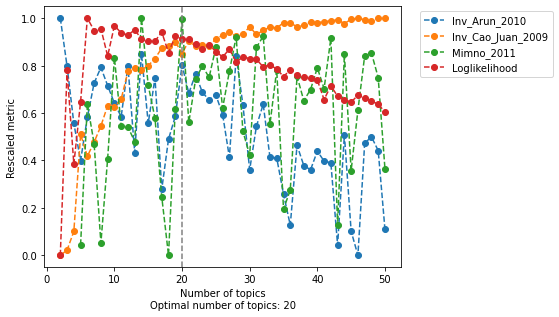

TXG_10xv2_adultmousecortex.FULL
cistopic_objects/TXG_10xv2_adultmousecortex.FULL__cto.scrublet0-4.fmx.singlets.model_18topics.pkl
	Loaded models__screen__mallet/TXG_10xv2_adultmousecortex.FULL__models_400_iter.pkl, evaluating...


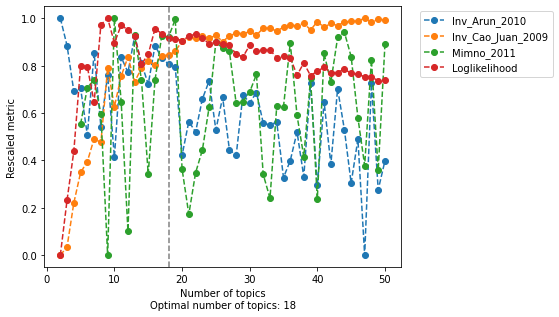

TXG_10xv2_adultmousecortexchromiumx.FULL
cistopic_objects/TXG_10xv2_adultmousecortexchromiumx.FULL__cto.scrublet0-4.fmx.singlets.model_15topics.pkl
	Loaded models__screen__mallet/TXG_10xv2_adultmousecortexchromiumx.FULL__models_400_iter.pkl, evaluating...


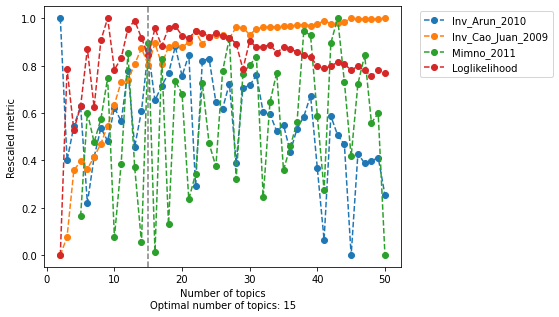

VIB_hydrop_1.FULL
cistopic_objects/VIB_hydrop_1.FULL__cto.scrublet0-4.fmx.singlets.model_19topics.pkl
	Loaded models__screen__mallet/VIB_hydrop_1.FULL__models_400_iter.pkl, evaluating...


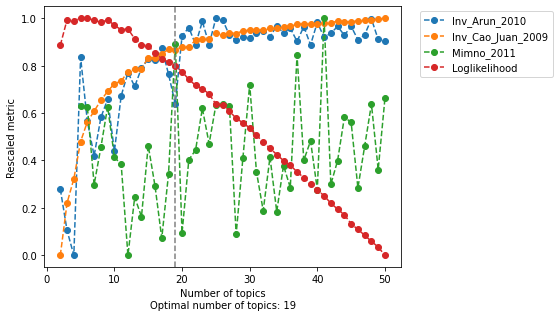

VIB_hydrop_2.FULL
cistopic_objects/VIB_hydrop_2.FULL__cto.scrublet0-4.fmx.singlets.model_14topics.pkl
	Loaded models__screen__mallet/VIB_hydrop_2.FULL__models_400_iter.pkl, evaluating...


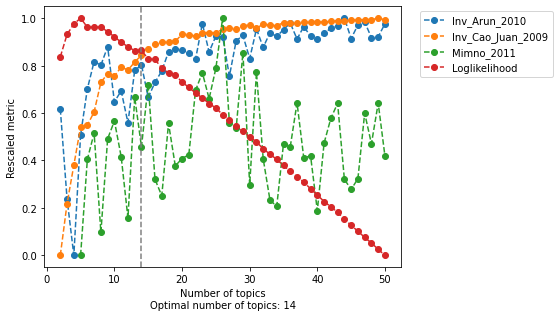

VIB_hydrop_3.FULL
cistopic_objects/VIB_hydrop_3.FULL__cto.scrublet0-4.fmx.singlets.model_14topics.pkl
	Loaded models__screen__mallet/VIB_hydrop_3.FULL__models_400_iter.pkl, evaluating...


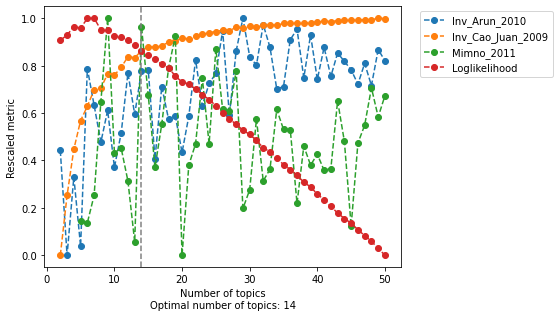

VIB_hydrop_4.FULL
cistopic_objects/VIB_hydrop_4.FULL__cto.scrublet0-4.fmx.singlets.model_15topics.pkl
	Loaded models__screen__mallet/VIB_hydrop_4.FULL__models_400_iter.pkl, evaluating...


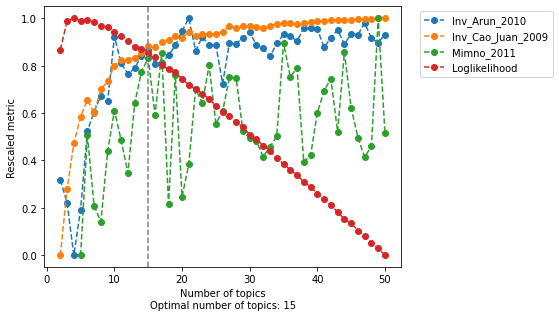

VIB_hydrop_5.FULL
cistopic_objects/VIB_hydrop_5.FULL__cto.scrublet0-4.fmx.singlets.model_12topics.pkl
	Loaded models__screen__mallet/VIB_hydrop_5.FULL__models_400_iter.pkl, evaluating...


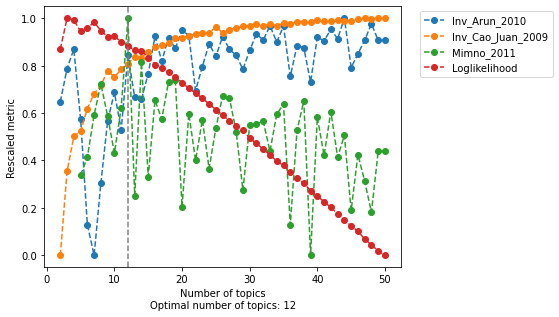

In [30]:
write = True
for sample in optimal_topics_dict.keys():
    # for sample in ['VIB_hydrop_2.FIXEDCELLS']:
    cto_path = cto_singlets_path_dict[sample]
    print(sample)
    ntopics = optimal_topics_dict[sample]
    cto_path_new = cto_path.replace(".pkl", f".model_{ntopics}topics.pkl")
    print(cto_path_new)
    if not os.path.isfile(cto_path_new):
        if sample in list(models_path_dict.keys()):
            models_path = models_path_dict[sample]
            with open(models_path, "rb") as f:
                models = pickle.load(f)

            print(f"\tLoaded {models_path}, evaluating...")
            model = evaluate_models(
                models,
                select_model=optimal_topics_dict[sample],
                return_model=True,
                metrics=["Arun_2010", "Cao_Juan_2009", "Minmo_2011", "loglikelihood"],
                plot=True,  # disabled since we only test one model here
                plot_metrics=False,
                save=f"plots_qc/{sample}__model_evaluation.png",
            )

            if write == True:
                with open(cto_path, "rb") as f:
                    cto = pickle.load(f)

                cto.add_LDA_model(model)

                with open(cto_path_new, "wb") as f:
                    pickle.dump(cto, f, protocol=4)

        else:
            print(f"\t{sample} models does not exist!")
    else:
        print(f"\t{cto_path_new} already exists! Skipping...")